In [1]:
import refinitiv.data as rd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD

2024-12-16 07:21:31.534250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load dataset

In [2]:
security = 'SGD='
date_0 = '2019-11-01'
date_1 = '2024-12-01'

rd.open_session()
markets = rd.get_history(universe=[security], fields=['MID_PRICE'],
                         interval="1d", start=date_0, end=date_1
                    )

df = markets

train = df.iloc[:int(len(df)*0.8)]
test = df.iloc[int(len(df)*0.8):]

Manage data format and scales

In [3]:
dataset_train = train.MID_PRICE.values
dataset_train = np.reshape(dataset_train, (-1,1))

dataset_test = test.MID_PRICE.values
dataset_test = np.reshape(dataset_test, (-1,1))

scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.fit_transform(dataset_test)

Divide time series into a supervised learning problem.  
It's meant to say that the first 49 observation, determined the value in 50th.

In [4]:
x_train = []
y_train = []
for i in range(50, len(scaled_train)):
    x_train.append(scaled_train[i-50:i, 0])
    y_train.append(scaled_train[i, 0])
    
x_test = []
y_test = []
for i in range(50, len(scaled_test)):
    x_test.append(scaled_test[i-50:i, 0])
    y_test.append(scaled_test[i, 0])


Reshaping for Neural Network Model

In [5]:
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

x_test, y_test = np.array(x_test), np.array(y_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

Simple RNN Model

In [6]:
# Initialise
regressor = Sequential()

# RNN layers and dropout regularisation
regressor.add(SimpleRNN(units = 50,
                       activation = 'tanh',
                       return_sequences = True,
                       input_shape = (x_train.shape[1],1)))
regressor.add(Dropout(0.2))
regressor.add(SimpleRNN(units = 50,
                       activation = 'tanh',
                       return_sequences = True))
regressor.add(SimpleRNN(units = 50,
                       activation = 'tanh',
                       return_sequences = True))
regressor.add(SimpleRNN(units = 50))

# Output layer
regressor.add(Dense(units = 1, activation = 'sigmoid'))

# Compile RNN
regressor.compile(optimizer = 
                  SGD(learning_rate = 0.01,
                     decay=1e-6,
                     momentum=0.9,
                     nesterov=True),
                 loss = 'mean_squared_error')

# Fit RNN
regressor.fit(x_train, y_train, epochs = 20, batch_size = 2)
regressor.summary()

2024-12-16 07:21:42.041900: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
505/505 [==============================] - 21s 37ms/step - loss: 0.0068
Epoch 2/20
505/505 [==============================] - 18s 36ms/step - loss: 0.0036
Epoch 3/20
505/505 [==============================] - 18s 35ms/step - loss: 0.0030
Epoch 4/20
505/505 [==============================] - 18s 37ms/step - loss: 0.0027
Epoch 5/20
505/505 [==============================] - 18s 36ms/step - loss: 0.0024
Epoch 6/20
505/505 [==============================] - 19s 38ms/step - loss: 0.0021
Epoch 7/20
505/505 [==============================] - 19s 37ms/step - loss: 0.0020
Epoch 8/20
505/505 [==============================] - 18s 36ms/step - loss: 0.0021
Epoch 9/20
505/505 [==============================] - 18s 35ms/step - loss: 0.0017
Epoch 10/20
505/505 [==============================] - 19s 38ms/step - loss: 0.0017
Epoch 11/20
505/505 [==============================] - 19s 38ms/step - loss: 0.0017
Epoch 12/20
505/505 [==============================] - 18s 36ms/step - loss: 0.0017
E

7/7 [==============================] - 1s 16ms/step


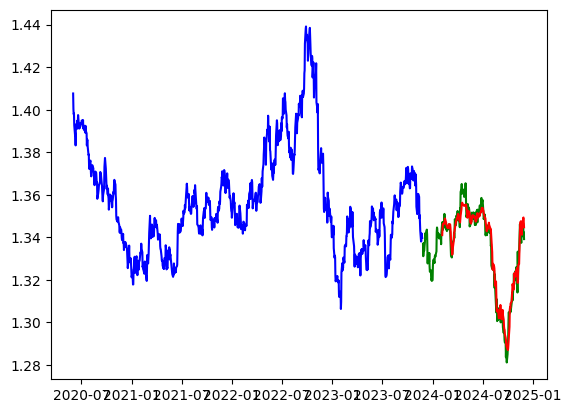

In [7]:
y_RNN = regressor.predict(x_test)
y_RNN_O = scaler.inverse_transform(y_RNN)

plt.plot(train.index[150:], train[150:].values, label="train", color='b')
plt.plot(test.index, test.values, label='test', color = 'g')
plt.plot(test.index[50:], y_RNN_O, label='RNN', color = 'r')
plt.show()

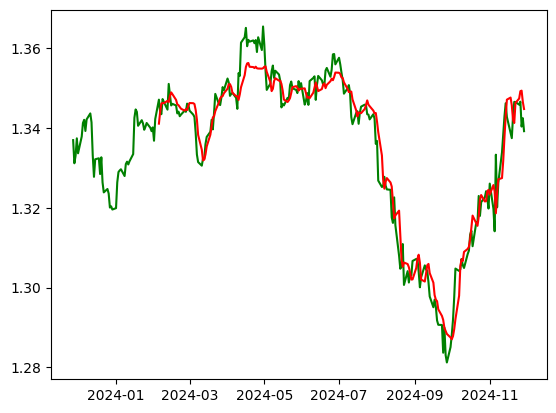

In [8]:
plt.plot(test.index, test.values, label='test', color = 'g')
plt.plot(test.index[50:], y_RNN_O, label='RNN', color = 'r')
plt.show()